<font size="6" style="color:#ce4257">AMEX : Data cleaning</font>

<font size="5" style="color:#219ebc">Table of contents</font>

- [Memory Usage : Datatype conversion](#0)

- [Feture engineering](#1)

- [Removing irrelevant data](#2)

- [Handling missing data](#3)



In [1]:
%%capture --no-display

import pandas as pd 
import numpy as np 

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,rgb2hex 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import gc

In [2]:
def get_colormap(N:int=20):
    """
        Returns a rgb and hex cyan to pink colormap with the specified number of segmentations.
    """
    rgb_colors = LinearSegmentedColormap.from_list('my_colormap',
                                    ['#bbd5de','#6495ed','#ff355d'],
                                    N=N)
    hex_colors = [rgb2hex(rgb_colors(i)) for i in range(rgb_colors.N)]
    return rgb_colors,hex_colors

In [3]:
TRAIN_CSV = '../input/amexfeather/train_data.ftr'

In [4]:
train_df = pd.read_feather(TRAIN_CSV)

<font size="5" style="color:#219ebc">Memory Usage : Datatype conversion</font>
<div id="0">

Tools like Spark can easily handle large datasets (100's of GB to TB), but taking full advantage of their capabilities usually requires some kind of distributed system. Unlike pandas, it lacks rich feature sets for high quality data cleaning, exploration, and analysis. So, for medium-sized data like this we’re better off trying to get more out of pandas, rather than switching to a different tool.

Here are some tips to reduce the memory usage :

- Tip 1: Free Memory using gc.collect(): 
In python notebook once a dataset loads into RAM it does not free on its own.So if we load a huge dataframe like above into pandas, and then make a copy of it and never use it again, that original dataframe will still be in RAM consuming memory.Therefore we should adopt the habit of deleting dataframe when it is no longer in use to save memory.

- Tip 2: Datatype Conversions: 
We can verify the data type used in every feature and convert them to a more suitable type in order to better fit the variable characteristincs and avoid precision redundancy.

- Tip 3: Memory leaks: 
We can avoid memory leaks by removing temporary variables when we no longer need them.The better method of avoiding memory leaks is doing data processing inside a function. It creates a new scope for the intermediate variables and removes them automatically when the interpreter exits the function.

In [5]:
def get_nunique_features(df:pd.DataFrame,thres:int=50)->list:
    """
        Returns the column names that have less unique values than the specified threshold.
    """
    cat_features = []
    for column in df.columns:
        uniques = np.sort(df[column].dropna().unique())
        num_unique = len(uniques)
        if (num_unique<thres):
            print(f'Column {column} has : {num_unique} unique values , ranging from {uniques[0]} to {uniques[-1]} ({df[column].dtype})')
            cat_features.append(column)
    return cat_features


- We can see that tere are some numerical data type features that have only a few possible values, we can convert them to category. 

- D_87 seems to have only one posible value (1), that might be due to a high percetage of nan values.

In [6]:
cat_features = get_nunique_features(train_df)
train_df[cat_features] = train_df[cat_features].astype('category')

del cat_features

Column D_63 has : 6 unique values , ranging from CL to XZ (category)
Column D_64 has : 5 unique values , ranging from  to U (category)
Column D_66 has : 2 unique values , ranging from 0.0 to 1.0 (category)
Column D_68 has : 7 unique values , ranging from 0.0 to 6.0 (category)
Column B_30 has : 3 unique values , ranging from 0.0 to 2.0 (category)
Column D_87 has : 1 unique values , ranging from 1.0 to 1.0 (float16)
Column B_31 has : 2 unique values , ranging from 0.0 to 1.0 (float16)
Column B_38 has : 7 unique values , ranging from 1.0 to 7.0 (category)
Column D_114 has : 2 unique values , ranging from 0.0 to 1.0 (category)
Column D_116 has : 2 unique values , ranging from 0.0 to 1.0 (category)
Column D_117 has : 7 unique values , ranging from -1.0 to 6.0 (category)
Column D_120 has : 2 unique values , ranging from 0.0 to 1.0 (category)
Column D_126 has : 3 unique values , ranging from -1.0 to 1.0 (category)
Column target has : 2 unique values , ranging from 0 to 1 (int64)


- The continous variables seems to have the lowest precision possible (16 bits) so no neeed to convert those

In [7]:
train_df.dtypes.astype(str).value_counts()

float16           175
category           14
object              1
datetime64[ns]      1
dtype: int64

<font size="5" style="color:#219ebc">Removing irrelevant data</font>
<div id="1">

In general, it is recommended to avoid having correlated features. 

A group of highly correlated features will not bring additional information and will increase the complexity of the algorithm.

In [8]:
def get_numerical_correlated(df:pd.DataFrame,thresh:float=0.99)->list:  
    """
        Returns a list containing the features that have a linear correlation greater than the specified threshold.
    """
    high_correlated_features=[]
    df = df.select_dtypes(include=np.number)
    corr=df.sample(1000000).corr()
    for feature in range(len(corr)):
        for other_feature in range(len(corr)):
            
            if feature!=other_feature and \
               df.columns[other_feature] not in high_correlated_features and \
               abs(corr.iloc[feature][other_feature]) >= thresh:
                
                print(f"{df.columns[feature]} and {df.columns[other_feature]} are highly correlated ({corr.iloc[feature][other_feature]:.3f})") 
                high_correlated_features.append(df.columns[feature])
                break
    return high_correlated_features 

In [9]:
dependent_features= get_numerical_correlated(train_df,0.99)

B_1 and B_11 are highly correlated (0.996)
B_7 and B_23 are highly correlated (0.995)
D_62 and D_77 are highly correlated (1.000)
D_103 and D_104 are highly correlated (1.000)
D_118 and D_119 are highly correlated (0.995)
D_139 and D_141 are highly correlated (0.998)
D_141 and D_143 are highly correlated (0.998)


In [10]:
print(*dependent_features)

B_1 B_7 D_62 D_103 D_118 D_139 D_141


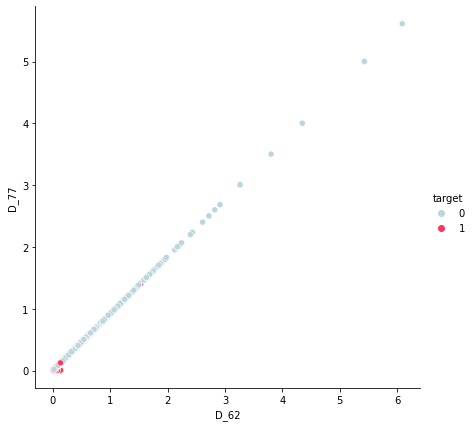

In [11]:
# Feature correlation pair plot example
sb.pairplot(data= train_df.sample(100000),x_vars='D_62',height=6,y_vars='D_77',hue='target',palette=get_colormap(2)[1]) 

In [12]:
train_df.drop(columns=dependent_features,inplace=True)
train_df

del dependent_features
gc.collect()

21

<font size="5" style="color:#219ebc">Feature engineering</font>
<div id="2">

To avoid working with such a large dataset, before continuing with the imputation, we are gonnna compress each customer history into a single row using aggregation functions such as mean, standard deviation, min/max and last for numerical features and unique class appearances,count and last for categoricals.

In [13]:
def aggregate_by_customer(df:pd.DataFrame)->pd.DataFrame:
    """
        Reduce each customer_ID records to a single row using aggregation functions.
    """
    cat_features = list(df.select_dtypes(include='category').columns)
    num_features = list(df.select_dtypes(include=np.number).columns)

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train_df = aggregate_by_customer(train_df)

shape after engineering (458913, 882)


In [14]:
train_df

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_117_nunique,D_120_count,D_120_last,D_120_nunique,D_126_count,D_126_last,D_126_nunique,target_count,target_last,target_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,1,13,0.0,1,13,1.0,1,13,0,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,1,13,0.0,2,13,1.0,1,13,0,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,1,13,0.0,1,13,1.0,1,13,0,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,2,13,0.0,1,13,1.0,1,13,0,1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,1,13,0.0,1,13,1.0,1,13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.041953,0.730469,0.895508,0.844238,0.119202,0.195267,0.002237,0.589844,0.447510,...,2,13,1.0,2,13,1.0,1,13,0,1
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.012459,0.831055,0.868164,0.831055,0.066406,0.123915,0.007328,0.478027,0.033661,...,2,13,0.0,1,13,1.0,1,13,0,1
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.014292,0.756836,0.802734,0.800293,0.221558,0.182736,0.000223,0.536133,0.267090,...,1,13,0.0,1,13,1.0,1,13,0,1


<font size="5" style="color:#219ebc">Handling missing data</font>
<div id="3">

If a value is missing becuase it doens't exist then it doesn't make sense to try and guess what it might be. These values we probalby do want to keep as NaN. On the other hand, if a value is missing becuase it wasn't recorded, then we can try to guess what it might have been based on the other values in that column and row. 
In this case we have the following variables:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

We can assume that delinquency/risks variables might have a valid missing value if the customer profile has no delinquency/default record.
But on the other hand for the payment, spend and balance variables there should not be any missing values since they are already customers, so we are gonna try to predict them.

The first method used below is a quite straightforward way of handling missing Data, which directly removes the variables that have missing data. We are going to consider to predict only those that have more than 20 percent of the total data.

In [15]:
def get_nan_percentages(df:pd.DataFrame,thresh:int=0)-> pd.DataFrame:
    """
       Returns the nan frequency percetages of features that surpass the specified threshold.
    """
    null_perc = df.isnull().sum().divide(len(df)).multiply(100).to_frame(name='Missing %')
    null_perc = null_perc[null_perc['Missing %']>=thresh].sort_values(by='Missing %')
    return null_perc

- We see that they are 22 features that have more than 80% nan values
- It seems to bee that the majority of them are delinquncy variables, lets filter those out and drop what is left.

In [16]:
missing_percentages = get_nan_percentages(train_df,80).transpose()
missing_percentages

,D_142_max,D_142_mean,D_142_min,D_142_last,D_142_std,D_49_mean,D_49_min,D_49_max,D_49_last,D_132_mean,...,D_110_mean,B_39_std,D_111_std,D_110_std,D_88_last,D_88_max,D_88_min,D_88_mean,D_88_std,D_87_last
Missing %,81.351585,81.351585,81.351585,81.351585,81.827057,86.573708,86.573708,86.573708,86.573708,86.574144,...,99.109417,99.139488,99.146025,99.146025,99.472885,99.472885,99.472885,99.472885,99.567674,99.819356


In [17]:
missing_percentages = missing_percentages.loc[:, ~missing_percentages.columns.str.startswith('D')&~missing_percentages.columns.str.startswith('R')]
missing_percentages

,B_29_last,B_29_max,B_29_min,B_29_mean,B_29_std,B_42_min,B_42_last,B_42_mean,B_42_max,B_42_std,B_39_last,B_39_max,B_39_min,B_39_mean,B_39_std
Missing %,91.978218,91.978218,91.978218,91.978218,92.1508,98.581648,98.581648,98.581648,98.581648,98.622615,99.105277,99.105277,99.105277,99.105277,99.139488


In [18]:
# We are now left with 180 features
train_df.drop(columns=missing_percentages.columns,inplace=True)
del missing_percentages
train_df.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_117_nunique,D_120_count,D_120_last,D_120_nunique,D_126_count,D_126_last,D_126_nunique,target_count,target_last,target_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,1,13,0.0,1,13,1.0,1,13,0,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,1,13,0.0,2,13,1.0,1,13,0,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,1,13,0.0,1,13,1.0,1,13,0,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,2,13,0.0,1,13,1.0,1,13,0,1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,1,13,0.0,1,13,1.0,1,13,0,1


<font size="5" style="color:#219ebc">Data imputation</font>
<div id="4">
    
Now that we ensure to have enough data to predict non delinquency/risks features, we continue by doing the imputation.

Imputation is a technique used for replacing the missing data with some substitute value to retain most of the data/information of the dataset. These techniques are used because removing the data from the dataset every time is not feasible and can lead to a reduction in the size of the dataset to a large extend, which not only raises concerns for biasing the dataset but also leads to incorrect analysis.

Here we will use an **Iterative imputation** technique wich refers to a process where each feature is predicted using a model based on the values of the other features.
Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features.

It is iterative because this process is repeated multiple times, allowing ever improved estimates of missing values to be calculated as missing values across all features are estimated.

This approach may be generally referred to as fully conditional specification (FCS) or multivariate imputation by chained equations (MICE).

In [19]:
impute_it = IterativeImputer(
    missing_values=np.nan,
    max_iter=16,
    tol=0.02,
    initial_strategy='mean',
    imputation_order='ascending',
    verbose=2,
    random_state=42
)

- Now we are gonna break down the imputation taking to account the features within each class.

In [20]:
# Balance, payment and spend features imputation
train_df.loc[:,train_df.columns.str.startswith('B')] =impute_it.fit_transform(train_df.loc[:,train_df.columns.str.startswith('B')])
train_df.loc[:,train_df.columns.str.startswith('P')] =impute_it.fit_transform(train_df.loc[:,train_df.columns.str.startswith('P')])
train_df.loc[:,train_df.columns.str.startswith('S')] =impute_it.fit_transform(train_df.loc[:,train_df.columns.str.startswith('S')])

[IterativeImputer] Completing matrix with shape (458913, 169)
[IterativeImputer] Ending imputation round 1/16, elapsed time 2320.12
[IterativeImputer] Change: 41.43966942287193, scaled tolerance: 115.12 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (458913, 15)
[IterativeImputer] Ending imputation round 1/16, elapsed time 7.58
[IterativeImputer] Change: 1.39176575795963, scaled tolerance: 0.0485546875 
[IterativeImputer] Ending imputation round 2/16, elapsed time 15.53
[IterativeImputer] Change: 0.42208973266762856, scaled tolerance: 0.0485546875 
[IterativeImputer] Ending imputation round 3/16, elapsed time 22.61
[IterativeImputer] Change: 0.3999663355267169, scaled tolerance: 0.0485546875 
[IterativeImputer] Ending imputation round 4/16, elapsed time 29.87
[IterativeImputer] Change: 0.328457641699976, scaled tolerance: 0.0485546875 
[IterativeImputer] Ending imputation round 5/16, elapsed time 37.22
[IterativeImputer] Change: 0.

In [21]:
# Final training set exportation
train_df.reset_index().to_feather('./train_df.ftr')